# Analysis of Single Cell Data from Iwasaki Flu Project
- Roy Jiang
- May 15, 2020
- Clone ID. Repertoire analysis for Diversity, Isotype, SHM, (Vgene). Features of overlapping PCs

# Before running

- This notebook assumes that the processing notebook has completed and changeo files have been generated. 

In [4]:
TENX_META_FILE = "/git/projects/Oh2022_SI/meta.csv"
CELLRANGER_DIR = "/data/cellranger"
LUNG_OBJECT = "/data/LungNorm.rds"
LN_OBJECT = "/data/LN.rds"

SATURN_SOURCE = "/git/pipeline_abseq/api/saturn/saturn.R"

### Generated by this notebook
OUT_TAB = "/data/out.tab"

### For outputting figures and tables
BASE_DIR = "/data"

In [2]:
mouse_ref_dir <- "/usr/local/share/germlines/imgt/mouse/vdj"

# Load libraries

In [2]:
source(SATURN_SOURCE)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [1]:
library(shazam)
library(alakazam)
library(ggforce)
library(tidyverse)

Loading required package: ggplot2
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [6]:
meta_df <- read.csv(TENX_META_FILE)

In [7]:
meta_df

IDX IDENTITY              SUBJECT STATUS NVE   
1 1   L4-BCR_VMT_cellranger P4      L      IMM   
2 2   L5-BCR_VMT_cellranger P5      L      IMM   
3 3   L6-BCR_VMT_cellranger P6      L      IMM   
4 4   LN-BCR_VMT_cellranger PN      L      NONIMM
5 5   M4-BCR_VMT_cellranger P4      M      IMM   
6 6   M5-BCR_VMT_cellranger P5      M      IMM   
7 7   M6-BCR_VMT_cellranger P6      M      IMM   
8 8   MN-BCR_VMT_cellranger PN      M      NONIMM

# Processing

In [347]:
hc_df <- meta_df %>%
    rowwise() %>%
    mutate(FILE = file.path(CELLRANGER_DIR, IDENTITY, "changeo", "filtered_contig_heavy_productive-T.tsv")) %>%
    ungroup() %>%
    select(IDX, FILE) %>%
    group_by(IDX) %>%
    do(read.csv(.$FILE, sep = '\t') %>% mutate_if(is.factor, as.character)) %>% ungroup() %>%
    left_join(meta_df, by="IDX")

lc_df <- meta_df %>%
    rowwise() %>%
    mutate(FILE = file.path(CELLRANGER_DIR, IDENTITY, "changeo", "filtered_contig_light_productive-T.tsv")) %>%
    ungroup() %>%
    select(IDX, FILE) %>%
    group_by(IDX) %>%
    do(read.csv(.$FILE, sep = '\t') %>% mutate_if(is.factor, as.character)) %>% ungroup() %>%
    left_join(meta_df, by="IDX")

In [348]:
hc_df %>% 
    group_by(IDENTITY) %>%
    summarize(COUNT = n())

IDENTITY              COUNT
1 L4-BCR_VMT_cellranger 4981 
2 L5-BCR_VMT_cellranger 3644 
3 L6-BCR_VMT_cellranger 4112 
4 LN-BCR_VMT_cellranger  322 
5 M4-BCR_VMT_cellranger 3836 
6 M5-BCR_VMT_cellranger 3599 
7 M6-BCR_VMT_cellranger 5356 
8 MN-BCR_VMT_cellranger 5595

### Define clones

In [40]:
# Compute DTN (do this first)
dtn_tab <- hc_df %>%
	    mutate(v_call = as.character(v_call), j_call = as.character(j_call)) %>%
	    group_by(SUBJECT) %>%
	    do(distToNearest(., 
                    sequenceColumn = "junction", 
                    vCallColumn = "v_call", 
                    jCallColumn = "j_call",
                    model="ham", first=FALSE, normalize="len", nproc=1)) %>%
	    ungroup() %>%
	    do(distToNearest(., 
                    sequenceColumn = "junction", 
                    vCallColumn = "v_call", 
                    jCallColumn = "j_call",
                    model="ham", first=FALSE, normalize="len", cross="SUBJECT", nproc=1))

dtn_sum <- dtn_tab %>%
    group_by(SUBJECT) %>%
    do(data.frame(DENSITY = hist(.$DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'DTN')

cross_sum <- dtn_tab %>%
    group_by(SUBJECT) %>%
    do(data.frame(DENSITY = -1 * hist(.$CROSS_DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'CROSS')

toplot_df <- bind_rows(dtn_sum, cross_sum)

In [51]:
# Find threshold 
thresh_df <- hc_df %>%
    mutate(JUNCTION = junction, V_CALL = v_call, J_CALL = j_call) %>%
	group_by(SUBJECT) %>%
	do(runShazam(., NPROC=8, SUBSAMPLE = 500)) %>% ungroup()

common_threshold <- thresh_df %>%
    group_by(SUBJECT) %>%
    summarize(MEAN = mean(as.numeric(threshold), na.rm = TRUE)) %>% ungroup() %>%
    summarize(THRESH = mean(MEAN, na.rm=TRUE), SD = sd(MEAN, na.rm=TRUE)) %>% select(THRESH) %>% unlist()

Warning message:
“`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session.”

Warning message:
“Removed 26 rows containing missing values (position_stack).”Warning message:
“Removed 26 rows containing missing values (position_stack).”

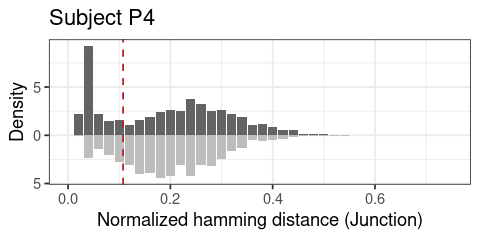

Warning message:
“Removed 26 rows containing missing values (position_stack).”

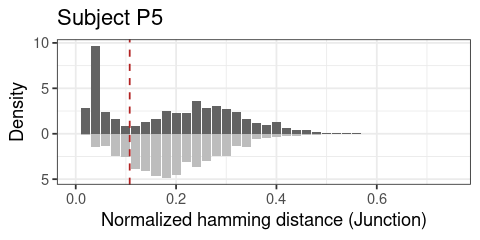

Warning message:
“Removed 26 rows containing missing values (position_stack).”

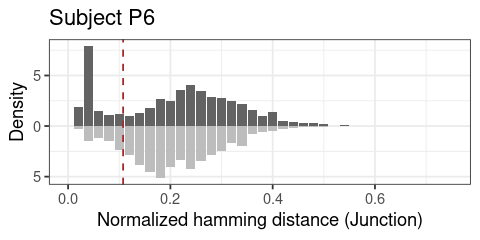

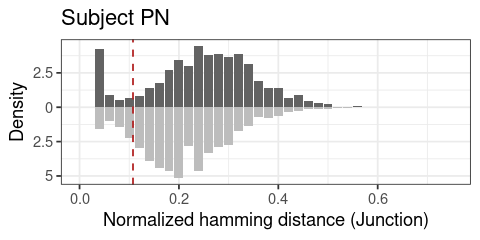

In [60]:
# Plot threshold and DTN

options(repr.plot.width = 4, repr.plot.height = 2)
DTN_COLORS <- c(
'DTN' = '#636363',
'CROSS' = '#BDBDBD'
)

for(subject in unique(toplot_df$SUBJECT)){
    
#   THRESHOLD <- thresh_df %>%
#         filter(PATIENT == patient) %>%
#         select(MEAN) %>% as.numeric()
    
#   THRESHOLD <- common_threshold

    p <- ggplot(filter(toplot_df, SUBJECT == subject), 
             aes(x=BINS, y=DENSITY, fill=TYPE)) + 
        baseTheme() + 
        theme_bw() + 
        theme(legend.position="none") +
        xlab("Normalized hamming distance (Junction)") + 
        ylab("Density") +
        ggtitle(paste("Subject", subject)) +
        geom_bar(stat = "identity") +
        geom_vline(xintercept=common_threshold, color="firebrick", linetype=2) +
        scale_x_continuous(limits=c(0,0.75)) +
        scale_y_continuous(labels=abs) +
        scale_color_manual(values=DTN_COLORS) +
        scale_fill_manual(values=DTN_COLORS)
        #facet_grid(. ~ SUBJECT) +
        #facet_wrap(~ Sample, ncol=4, scales = "free_y")
    plot(p)
    
}

In [349]:
# Single cell cloning, createGermlines, Mutations
hc_df <- hc_df %>% 
    bind_rows(lc_df) %>%
    group_by(SUBJECT) %>%
    do(singleCellClone(., clone_threshold = common_threshold) %>% mutate_if(is.factor, as.character)) %>%
    runCreateGermlines(ref_dir = mouse_ref_dir, format = "airr", v_call="v_call", sequence="sequence_alignment") %>% 
    observedMutations(sequenceColumn = "sequence_alignment",
                      germlineColumn = "germline_alignment_d_mask", 
                      frequency=TRUE) %>% mutate(MU_FREQ = MU_FREQ_SEQ_R+MU_FREQ_SEQ_S)

In [350]:
hc_df %>% 
    group_by(identity) %>%
    summarize(COUNT = n())

identity              COUNT
1 L4-BCR_VMT_cellranger 4087 
2 L5-BCR_VMT_cellranger 3091 
3 L6-BCR_VMT_cellranger 3536 
4 LN-BCR_VMT_cellranger  289 
5 M4-BCR_VMT_cellranger 3249 
6 M5-BCR_VMT_cellranger 3008 
7 M6-BCR_VMT_cellranger 4151 
8 MN-BCR_VMT_cellranger 4153

In [353]:
hc_df <- hc_df %>%
    group_by(clone_id, subject) %>%
    mutate(span = if(length(unique(status)) == 2){"Mobile"}else{"Resident"}) %>% ungroup()

### Assign Clusters

In [40]:
SUBJECT_DICT <- c(
'1' = 'P4',
'2' = 'P5',
'3' = 'P6',
'4' = 'PN',
'5' = 'P4',
'6' = 'P5',
'7' = 'P6',
'8' = 'PN'  
)

NVE_DICT <- c(
'P4' = 'IMM',
'P5' = 'IMM',
'P6' = 'IMM',
'PN' = 'NONIMM'
)

In [34]:
mouse_lung_obj <- readRDS(LUNG_OBJECT)
mouse_lymph_obj <- readRDS(LN_OBJECT)

In [41]:
identity_df <- 
bind_rows(data.frame(cluster = mouse_lung_obj@active.ident) %>%
    tibble::rownames_to_column("cell_id") %>%
    rowwise() %>%
    mutate(sample = strsplit(cell_id, split = "_")[[1]][2],
           cell_id = strsplit(cell_id, split = "_")[[1]][1]) %>%
    #ungroup() %>%
    #mutate(sample=mouse_obj@meta.data$orig.ident) %>%
    rowwise() %>%
    mutate(subject = SUBJECT_DICT[sample],
          nve = NVE_DICT[subject],
          status = 'L'
          )
,
data.frame(cluster = mouse_lymph_obj@active.ident) %>%
    tibble::rownames_to_column("cell_id") %>%
    rowwise() %>%
    mutate(sample = strsplit(cell_id, split = "_")[[1]][2],
           cell_id = strsplit(cell_id, split = "_")[[1]][1]) %>%
    #ungroup() %>%
    #mutate(sample=mouse_obj@meta.data$orig.ident) %>%
    rowwise() %>%
    mutate(subject = SUBJECT_DICT[sample],
          nve = NVE_DICT[subject],
          status = 'M'
          )
)

In [43]:
identity_df %>% group_by(sample) %>% summarize(COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)


sample COUNT
1 1       9432
2 2      12765
3 3      12343
4 4        363
5 5       5802
6 6       4089
7 7       5671
8 8       5568

In [46]:
hc_df <- hc_df %>%
    select(-nve, -sample, -cluster)

In [47]:
hc_df <- hc_df %>%
    left_join(identity_df, by=c("cell_id", "status", "subject")) %>%
    mutate(span = factor(span, levels=c("Resident", "Mobile")), 
           nve = factor(nve, levels=c("NONIMM", "IMM")), 
           subject = factor(subject, levels=c("P4", "P5", "P6", "PN")),
           cluster = factor(cluster, levels=sort(unique(identity_df$cluster))))

In [48]:
hc_df %>% 
    drop_na(cluster) %>%
    group_by(subject, status) %>% 
    summarize(COUNT = n())

`summarise()` regrouping output by 'subject' (override with `.groups` argument)


subject status COUNT
1 P4      L      4042 
2 P4      M      3216 
3 P5      L      3065 
4 P5      M      2945 
5 P6      L      3444 
6 P6      M      3940 
7 PN      L       289 
8 PN      M      4103

### Read/write

In [49]:
hc_df %>% 
    write.table(OUT_TAB, sep="\t")

In [45]:
hc_df <- read.csv(OUT_TAB, sep="\t")

# Compute overlap
- Visualize as venn diagram

In [50]:
overlap_df <- hc_df %>%
    group_by(subject) %>%
    do(runQuantifyOverlap(., group="status", clone="clone_id", action="count_bool")  
       %>% mutate_if(is.factor, as.character))

In [51]:
overlap_df <- overlap_df %>% 
    filter(!(index != 'M' & status != 'L')) %>% ungroup()

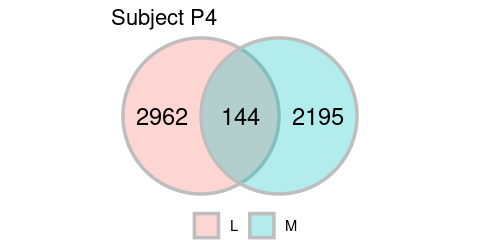

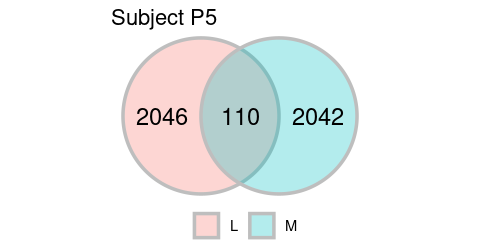

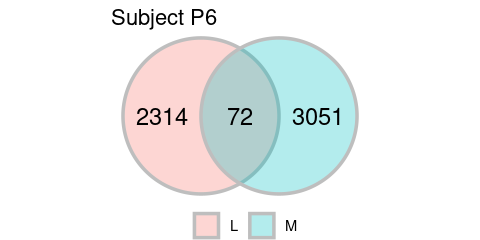

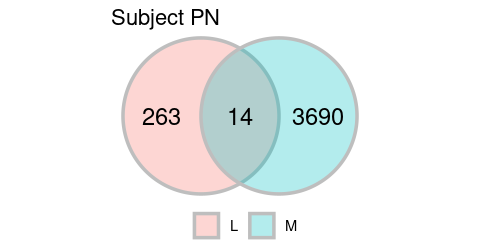

In [232]:
df.venn <- data.frame(x = c(-0.5, 0.5),
                          y = c(0,0),
                          labels = c("L", "M"))

df.vdc <- data.frame(x = c(-1, 0, 1),
                       y = c(0,0,0))

for(subj in unique(meta_df$SUBJECT)){
    df.vdc <- df.vdc %>%
        mutate(label = overlap_df %>% filter(subject == subj) %>% select(OVERLAP) %>% unlist())
    
    p <- ggplot(df.venn) +
        geom_circle(aes(x0 = x, y0 = y, r = 1, fill = labels), alpha = .3, size = 1, colour = 'grey') +
        coord_fixed() +
        theme_void() +
        ggtitle(paste("Subject", subj)) +
         theme(legend.position = 'bottom') +
    #   scale_fill_manual(values = TIME_COLORS) +
    #   scale_colour_manual(values = TIME_COLORS, guide = FALSE) +
          labs(fill = NULL) +
        annotate("text", x = df.vdc$x, y = df.vdc$y, label = df.vdc$label, size = 5)
    plot(p)
}

# Features of the compartments
- Diversity
- Isotype 
- SHM

In [274]:
div <- alphaDiversity(hc_df, group="identity", 
                           clone="clone_id", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=100, min_n=10)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(clone)` instead of `clone` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [382]:
even <- div@diversity %>%
    rename(IDENTITY = identity) %>%
    left_join(meta_df, by="IDENTITY")

Warning message:
“Column `IDENTITY` joining character vector and factor, coercing into character vector”

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


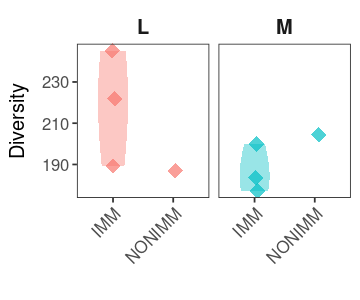

In [345]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even %>% filter(Q==2), aes(x=NVE, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
#    scale_y_continuous(breaks=seq(0, 300, 20), limits=c(20,300)) +
#     scale_fill_manual(values=TIME_COLORS, name="Status") +
#     scale_color_manual(values=TIME_COLORS, name="Status") +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
#     geom_errorbarh(data=even_sum, 
#                    aes(x=TIME, y=MEAN, color=TIME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
#                    height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

In [602]:
isotype_tab <- hc_df %>%
    group_by(status, subject, c_call, nve) %>%
    summarize(COUNT=n()) %>%
    group_by(status, subject, nve) %>%
    mutate(FREQ=COUNT/sum(COUNT, na.rm=T))  %>%
    group_by(c_call) %>%
    complete(nesting(subject, nve), status, fill = list(COUNT = 0, FREQ = 0)) 

Warning message:
“Grouping rowwise data frame strips rowwise nature”

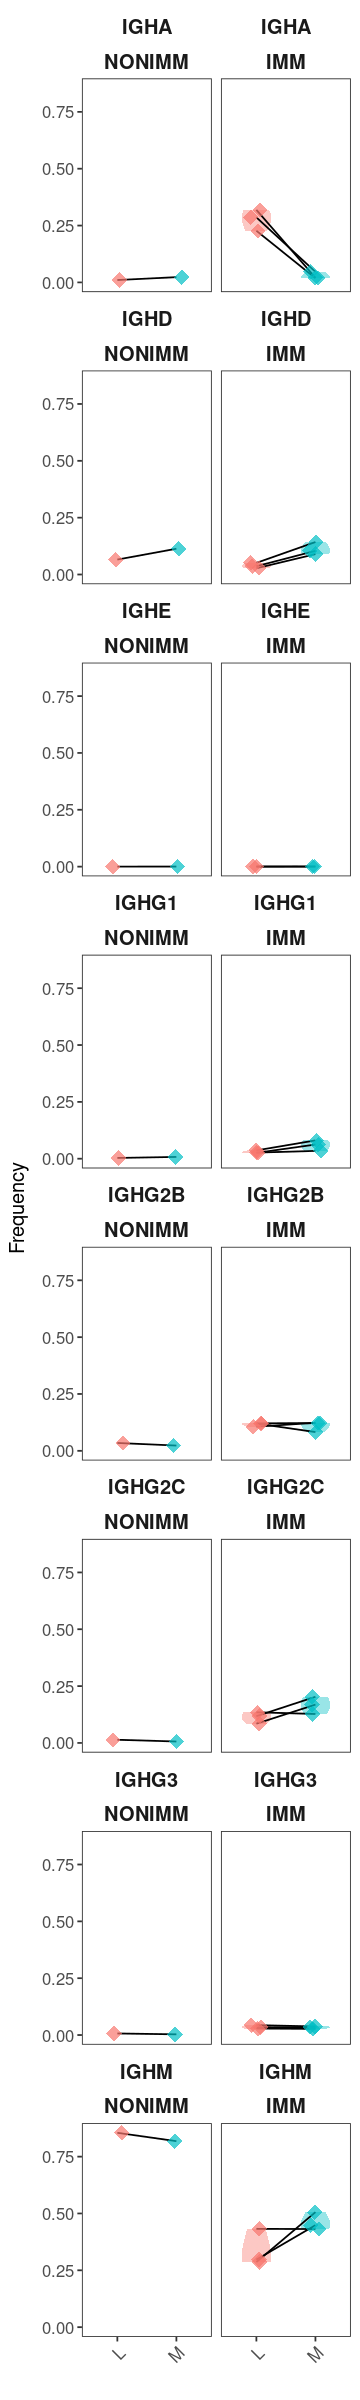

In [604]:
options(repr.plot.width=3, repr.plot.height=20)

p <- ggplot(isotype_tab %>% filter(c_call != ""), aes(x=status, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
#    scale_y_continuous(breaks=seq(0, 300, 20), limits=c(20,300)) +
#     scale_fill_manual(values=TIME_COLORS, name="Status") +
#     scale_color_manual(values=TIME_COLORS, name="Status") +
    geom_violin(aes(fill=status), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=subject)) +
#     geom_errorbarh(data=even_sum, 
#                    aes(x=TIME, y=MEAN, color=TIME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
#                    height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=status), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ c_call + nve, ncol=2, nrow=9)
plot(p)

In [605]:
mu_tab <- hc_df %>%
    group_by(status, subject, c_call, nve) %>%
    summarize(FREQ=mean(MU_FREQ))  

Warning message:
“Grouping rowwise data frame strips rowwise nature”

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


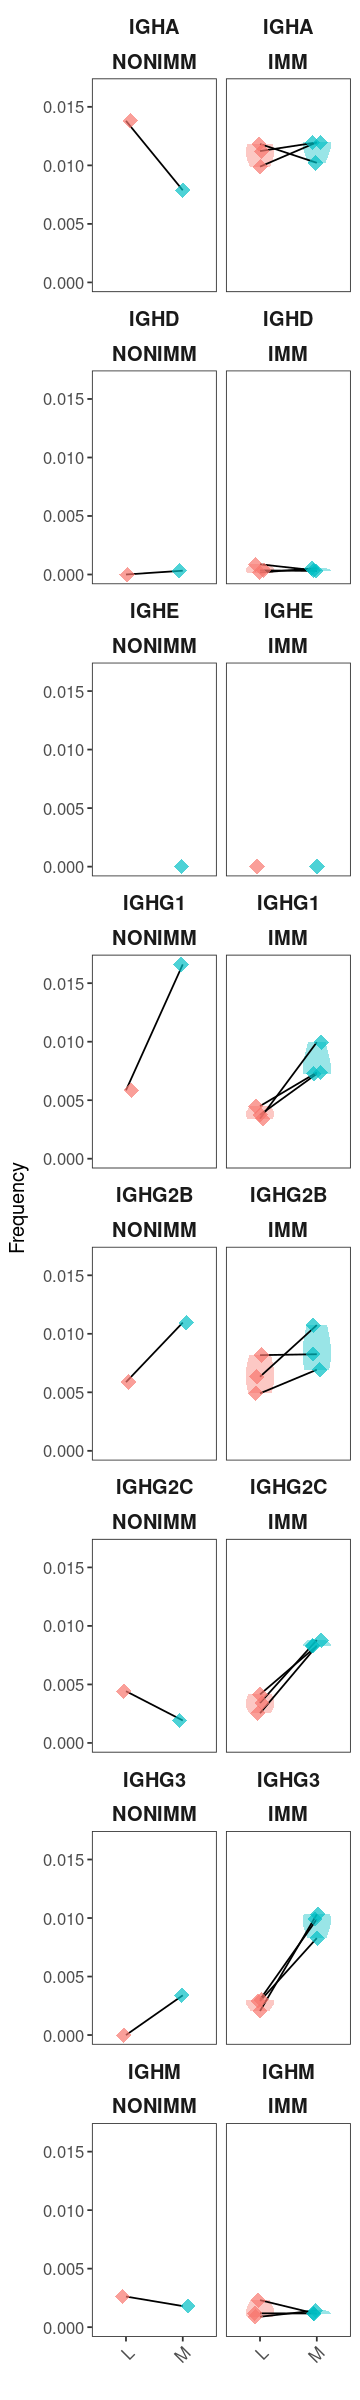

In [607]:
options(repr.plot.width=3, repr.plot.height=20)

p <- ggplot(mu_tab %>% filter(c_call != ""), aes(x=status, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
#    scale_y_continuous(breaks=seq(0, 300, 20), limits=c(20,300)) +
#     scale_fill_manual(values=TIME_COLORS, name="Status") +
#     scale_color_manual(values=TIME_COLORS, name="Status") +
    geom_violin(aes(fill=status), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=subject)) +
#     geom_errorbarh(data=even_sum, 
#                    aes(x=TIME, y=MEAN, color=TIME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
#                    height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=status), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ c_call + nve, ncol=2, nrow=9)
plot(p)

# Features of the overlap
- Diversity
- Isotype
- SHM 

In [290]:
div_span <- alphaDiversity(hc_df %>% mutate(identity_span = paste(identity, span, sep="@")), group="identity_span", 
                           clone="clone_id", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=100, min_n=10)

In [385]:
even_span <- div_span@diversity %>%
    rowwise() %>%
    mutate(IDENTITY = strsplit(identity_span, split ="@")[[1]][1], 
           span = strsplit(identity_span, split ="@")[[1]][2])  %>%
    left_join(meta_df, by="IDENTITY")

Warning message:
“Column `IDENTITY` joining character vector and factor, coercing into character vector”

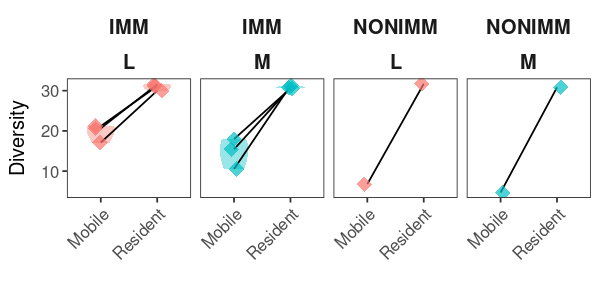

In [394]:
options(repr.plot.width=5, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2), aes(x=span, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ NVE+STATUS)
plot(p)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


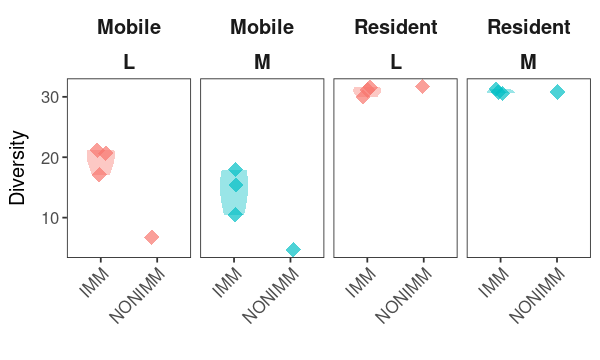

In [396]:
options(repr.plot.width=5, repr.plot.height=3)

p <- ggplot(even_span %>% filter(Q==2), aes(x=NVE, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ span+STATUS)
plot(p)

Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”

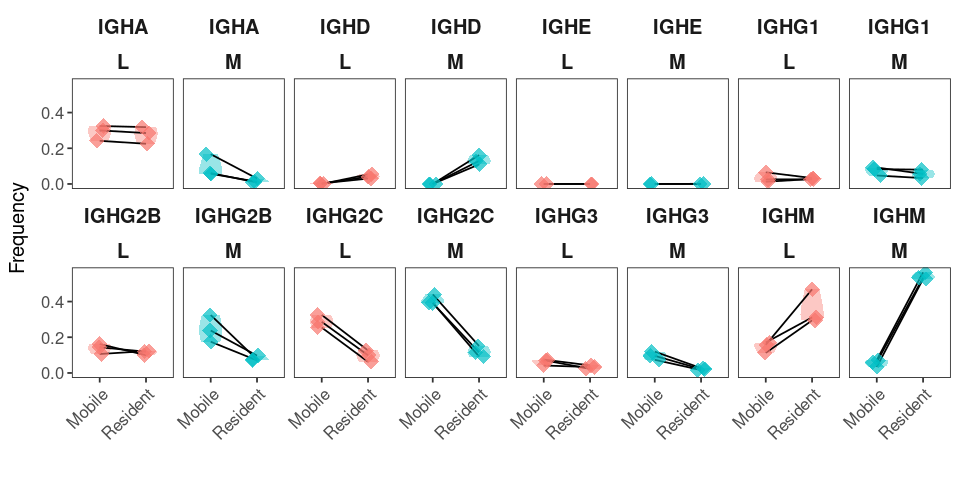

In [302]:
options(repr.plot.width=8, repr.plot.height=4)

p <- ggplot(isotype_span_tab %>% filter(c_call != "", nve=="IMM"), aes(x=span, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
#    scale_y_continuous(breaks=seq(0, 300, 20), limits=c(20,300)) +
#     scale_fill_manual(values=TIME_COLORS, name="Status") +
#     scale_color_manual(values=TIME_COLORS, name="Status") +
    geom_violin(aes(fill=status), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=subject)) +
#     geom_errorbarh(data=even_sum, 
#                    aes(x=TIME, y=MEAN, color=TIME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
#                    height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=status), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ c_call+status, ncol=8, nrow=4)
plot(p)

In [305]:
mu_span_tab <- hc_df %>%
    group_by(status, subject, c_call, span, nve) %>%
    summarize(FREQ=mean(MU_FREQ))  

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


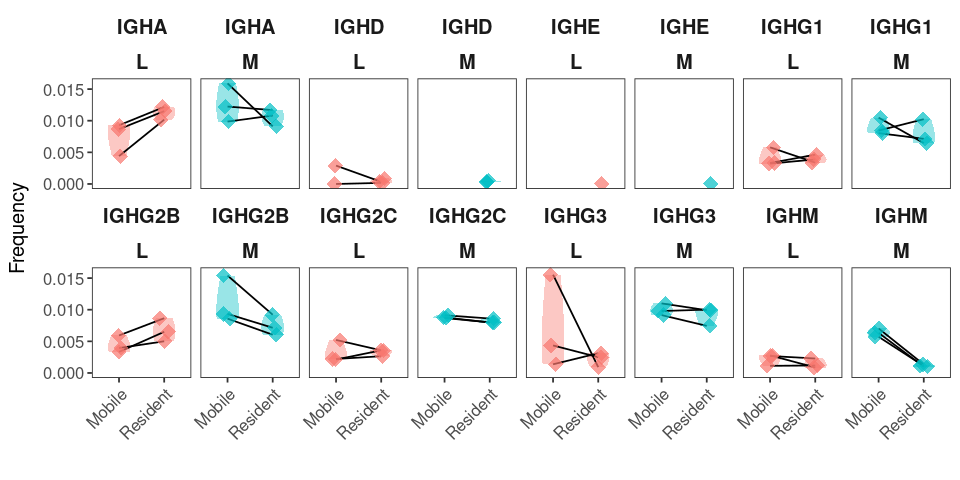

In [613]:
options(repr.plot.width=8, repr.plot.height=4)

p <- ggplot(mu_span_tab %>% filter(c_call != "", nve=="IMM"), aes(x=span, y=FREQ)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
#    scale_y_continuous(breaks=seq(0, 300, 20), limits=c(20,300)) +
#     scale_fill_manual(values=TIME_COLORS, name="Status") +
#     scale_color_manual(values=TIME_COLORS, name="Status") +
    geom_violin(aes(fill=status), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group=subject)) +
#     geom_errorbarh(data=even_sum, 
#                    aes(x=TIME, y=MEAN, color=TIME, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
#                    height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=status), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ c_call+status, ncol=8, nrow=4)
plot(p)

# Distribution of shared clones among clusters

### Report the distribution PCs from LN found also in Lung
- Also with sample plotting 

In [195]:
# by clone
toplot <- pc_hc_df %>%
    filter(status == "M") %>%
    drop_na() %>%
    select(cluster, subject, nve, clone_id, span) %>%
    distinct() %>%
    group_by(cluster, subject, nve) %>%
    summarize(mobile = mean(span == 'Mobile'), n_mobile = sum(span=='Mobile'))

`summarise()` regrouping output by 'cluster', 'subject' (override with `.groups` argument)


In [197]:
toplot %>% select(-mobile) %>% write.csv(file.path(BASE_DIR, "circos_input.csv"))

Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”

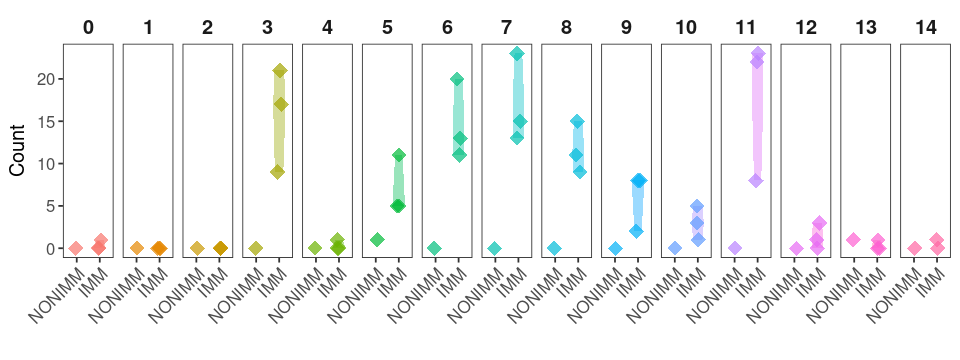

In [150]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(toplot, aes(x=nve, y=n_mobile)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Count")) +
    geom_violin(aes(fill=cluster), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_point(aes(color=cluster), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ cluster, ncol=15, nrow=2) 

Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”

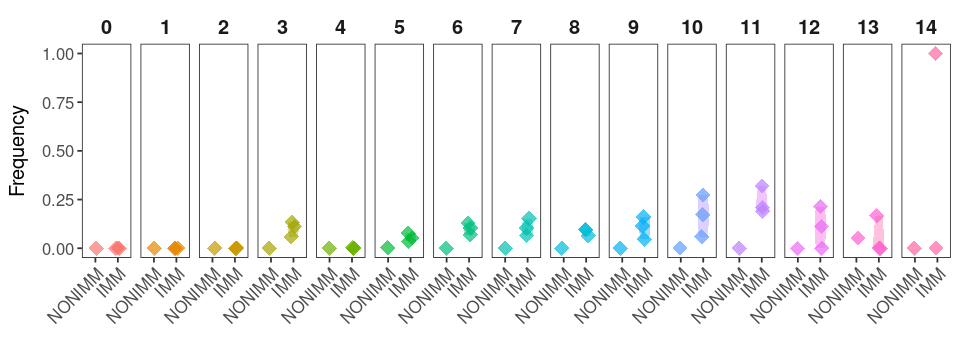

In [151]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(toplot, aes(x=nve, y=mobile)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Frequency")) +
    geom_violin(aes(fill=cluster), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_point(aes(color=cluster), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_wrap(. ~ cluster, ncol=15, nrow=2) 

### Report the distribution PCs from Lung found also in LN

In [205]:
lung_hc_df <- hc_df %>% 
    filter(!(status  == 'M')) %>%
    filter(!is.na(cluster)) %>%
    rowwise() %>%
    mutate(pc_cluster = if(cluster %in% c('5', '11')){'PC'}else{"Not PC"}) %>%
    group_by(clone_id, subject) %>%
    mutate(span = if(length(unique(pc_cluster)) == 2){"Mobile"}else{"Resident"}) %>% ungroup() 

In [208]:
toplot <- lung_hc_df %>%
    filter(pc_cluster == "Not PC") %>%
    drop_na() %>%
    select(cluster, subject, nve, clone_id, span) %>%
    distinct() %>%
    group_by(cluster, subject, nve) %>%
    summarize(mobile = mean(span == 'Mobile'), n_mobile = sum(span=='Mobile'))

`summarise()` regrouping output by 'cluster', 'subject' (override with `.groups` argument)


In [209]:
toplot

cluster subject nve    mobile      n_mobile
1  0       P4      IMM    0.000000000  0      
2  0       P5      IMM    0.006172840  1      
3  0       P6      IMM    0.002816901  1      
4  0       PN      NONIMM 0.000000000  0      
5  1       P4      IMM    0.085487078 43      
6  1       P5      IMM    0.138297872 65      
7  1       P6      IMM    0.107692308 49      
8  1       PN      NONIMM 0.000000000  0      
9  2       P4      IMM    0.112359551 80      
10 2       P5      IMM    0.192612137 73      
11 2       P6      IMM    0.149028078 69      
12 2       PN      NONIMM 0.000000000  0      
13 3       P4      IMM    0.000000000  0      
14 3       P5      IMM    0.004608295  1      
15 3       P6      IMM    0.005390836  2      
16 3       PN      NONIMM 0.000000000  0      
17 4       P4      IMM    0.011111111  5      
18 4       P5      IMM    0.007142857  1      
19 4       P6      IMM    0.000000000  0      
20 4       PN      NONIMM 0.009009009  1      
21 6       P4      IMM    0.145161290  9      
22 6       P5      IMM    0.193798450 25      
23 6       P6      IMM    0.072727273  4      
24 7       P4      IMM    0.081632653  4      
25 7       P5      IMM    0.179487179  7      
26 7       P6      IMM    0.204081633 10      
27 8       P4      IMM    0.129032258 12      
28 8       P5      IMM    0.213333333 32      
29 8       P6      IMM    0.151162791 13      
30 8       PN      NONIMM 0.000000000  0      
31 9       P4      IMM    0.067796610  4      
32 9       P5      IMM    0.285714286  2      
33 9       P6      IMM    0.176470588  3      
34 10      P4      IMM    0.200000000  3      
35 10      P5      IMM    0.055555556  1      
36 10      P6      IMM    0.000000000  0      
37 10      PN      NONIMM 0.000000000  0

In [210]:
toplot %>% select(-mobile) %>% write.csv(file.path(BASE_DIR, "circos_input_lung.csv"))

### Report the numbers of clones in each cluster

In [214]:
hc_df %>% 
    select(cluster, subject, nve, clone_id, status) %>%
    distinct() %>%
    group_by(cluster, subject, status, nve) %>%
    summarize(count = n()) %>%
    filter(!is.na(cluster))  %>% 
    write.csv(file.path(BASE_DIR, "clone_counts.csv"))

`summarise()` regrouping output by 'cluster', 'subject', 'status' (override with `.groups` argument)
